In [11]:
with open("tcpdump.txt", "r") as f:
    for i, line in enumerate(f):
        print(f"[{i+1}] {line.strip()}")
        if i == 4: break  # only first 5 lines


[1] 1   0.000000 20.52.64.201 â†’ 192.168.1.8  TCP 54 443 â†’ 53183 [RST, ACK] Seq=1 Ack=1 Win=0 Len=0
[2] 2   2.880997  192.168.1.8 â†’ 20.42.73.31  TCP 54 53202 â†’ 443 [FIN, ACK] Seq=1 Ack=1 Win=253 Len=0
[3] 3   2.881239 2401:4900:8840:b020:556f:99ec:de73:e6dd â†’ 2600:1417:56::174c:9d09 TCP 74 53200 â†’ 443 [FIN, ACK] Seq=1 Ack=1 Win=252 Len=0
[4] 4   2.881485  192.168.1.8 â†’ 204.79.197.222 TCP 54 53208 â†’ 443 [FIN, ACK] Seq=1 Ack=1 Win=252 Len=0
[5] 5   2.881591  192.168.1.8 â†’ 13.107.18.254 TCP 54 53205 â†’ 443 [FIN, ACK] Seq=1 Ack=1 Win=255 Len=0


In [15]:
import pandas as pd
import re

records = []

with open("tcpdump.txt", "r", encoding="utf-8") as f:
    for line in f:
        # Regex to match: time, source IP, dest IP, protocol, source port, dest port, and packet length
        match = re.search(
            r"\s*(\d+\.\d+)\s+([\da-fA-F\.:]+)\s+→\s+([\da-fA-F\.:]+)\s+(TCP|UDP)\s+\d+\s+(\d+)\s+→\s+(\d+).*Len=(\d+)",
            line
        )
        if match:
            time, src_ip, dst_ip, proto, src_port, dst_port, length = match.groups()
            app = "HTTPS" if int(dst_port) == 443 else "OTHER"
            records.append({
                "time": float(time),
                "src_ip": src_ip,
                "dst_ip": dst_ip,
                "protocol": proto,
                "src_port": int(src_port),
                "dst_port": int(dst_port),
                "length": int(length),
                "application": app
            })

# Create DataFrame
df = pd.DataFrame(records)
print(df.head())


       time                                   src_ip                   dst_ip  \
0  0.000000                             20.52.64.201              192.168.1.8   
1  2.880997                              192.168.1.8              20.42.73.31   
2  2.881239  2401:4900:8840:b020:556f:99ec:de73:e6dd  2600:1417:56::174c:9d09   
3  2.881485                              192.168.1.8           204.79.197.222   
4  2.881591                              192.168.1.8            13.107.18.254   

  protocol  src_port  dst_port  length application  
0      TCP       443     53183       0       OTHER  
1      TCP     53202       443       0       HTTPS  
2      TCP     53200       443       0       HTTPS  
3      TCP     53208       443       0       HTTPS  
4      TCP     53205       443       0       HTTPS  


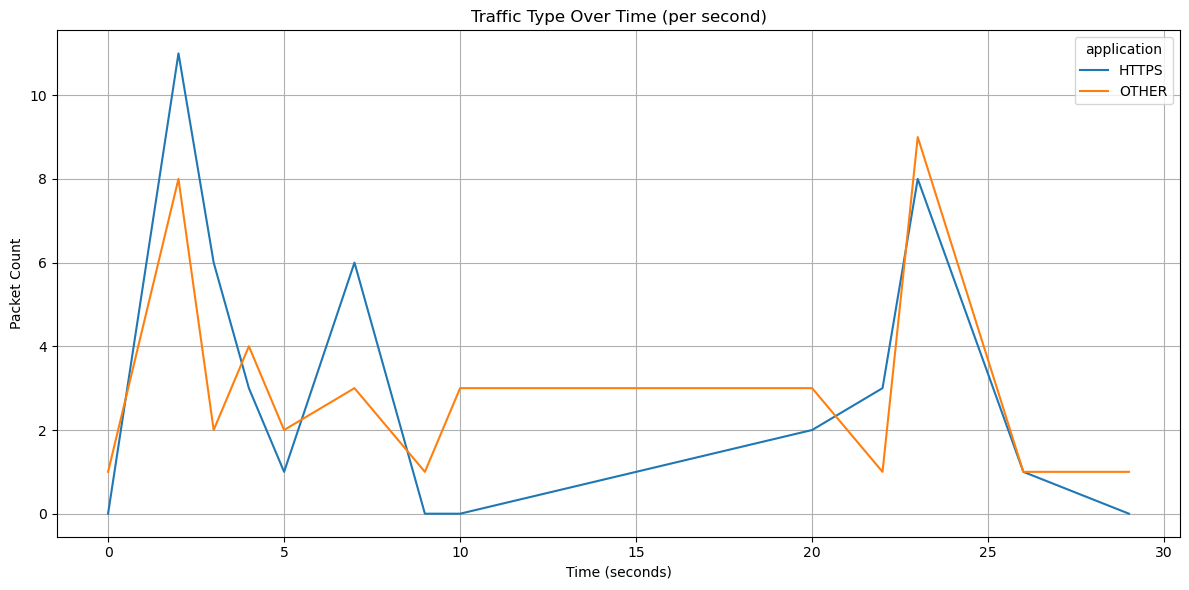

In [17]:
import matplotlib.pyplot as plt

# Create time bucket (rounded down)
df["time_bucket"] = df["time"].astype(int)

# Group by time and application
grouped = df.groupby(["time_bucket", "application"]).size().unstack(fill_value=0)

# Plot traffic type trends
grouped.plot(kind="line", figsize=(12, 6), title="Traffic Type Over Time (per second)")
plt.xlabel("Time (seconds)")
plt.ylabel("Packet Count")
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Prepare features and labels
X = df[["protocol", "src_port", "dst_port", "length"]].copy()
X["protocol"] = LabelEncoder().fit_transform(X["protocol"])
y = df["application"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Predict & evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       HTTPS       1.00      1.00      1.00         6
       OTHER       1.00      1.00      1.00        10

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



In [21]:
df.to_csv("parsed__tcpdump2.csv", index=False)


In [23]:
print(df["dst_port"].value_counts().head(10))


dst_port
443      41
53221     5
53218     5
53222     4
53193     3
53207     2
53205     2
53204     2
52443     2
53183     1
Name: count, dtype: int64


In [25]:
port_map = {
    443: "HTTPS", 80: "HTTP", 53: "DNS", 22: "SSH", 25: "SMTP", 110: "POP3", 5228: "FCM"
}
df["application"] = df["dst_port"].map(port_map).fillna("OTHER")


<Axes: xlabel='time_bucket', ylabel='application'>

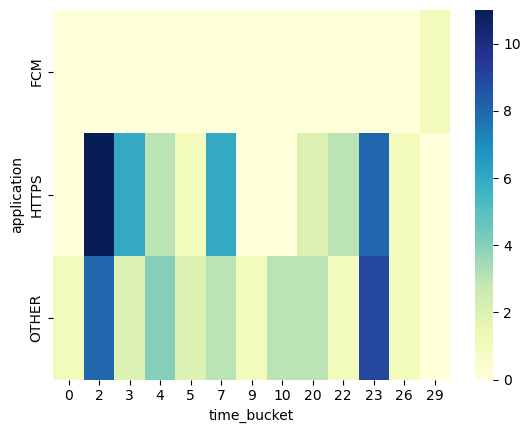

In [27]:
import seaborn as sns

pivot = df.groupby(["time_bucket", "application"]).size().unstack(fill_value=0)
sns.heatmap(pivot.T, cmap="YlGnBu")


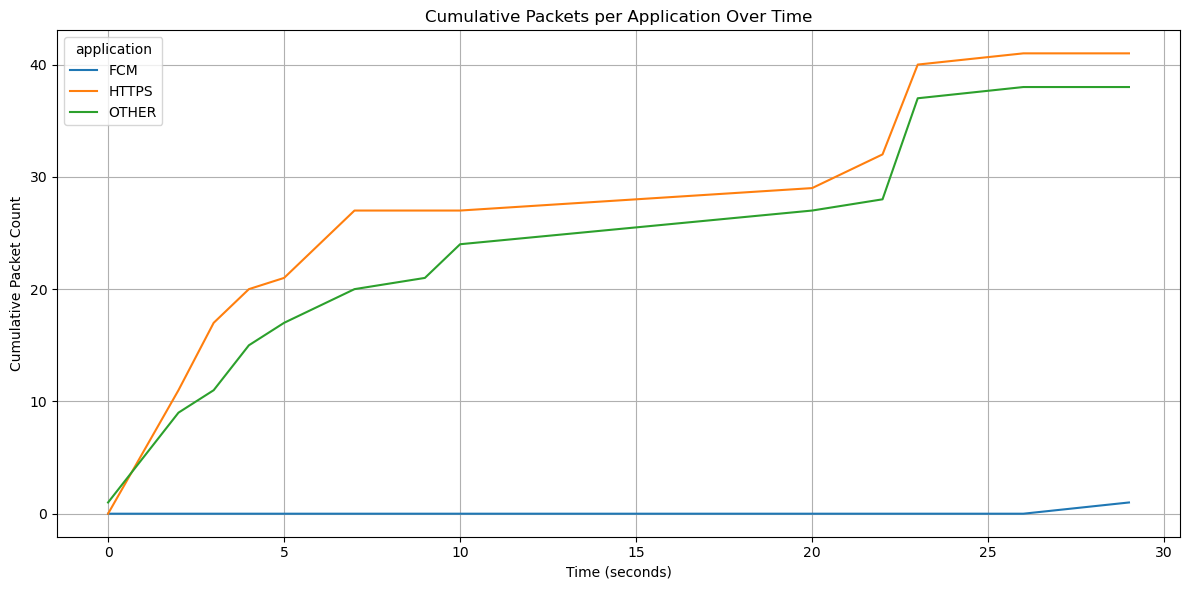

In [31]:
import matplotlib.pyplot as plt

# Ensure time is in integer seconds
df["time_bucket"] = df["time"].astype(int)

# Count packets per app per second
packet_counts = df.groupby(["time_bucket", "application"]).size().unstack(fill_value=0)

# Compute cumulative sum over time
cumulative = packet_counts.cumsum()

# Plot
cumulative.plot(figsize=(12, 6), title="Cumulative Packets per Application Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Cumulative Packet Count")
plt.grid(True)
plt.tight_layout()
plt.show()


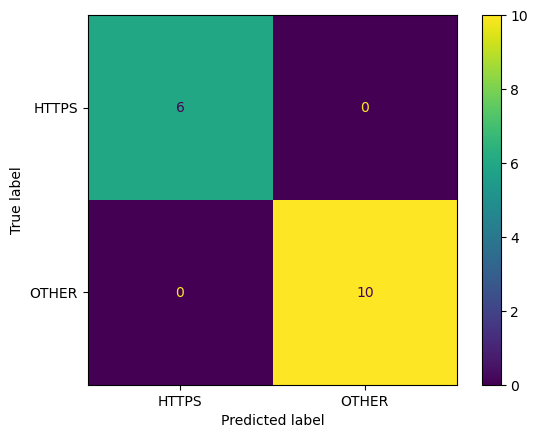

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()


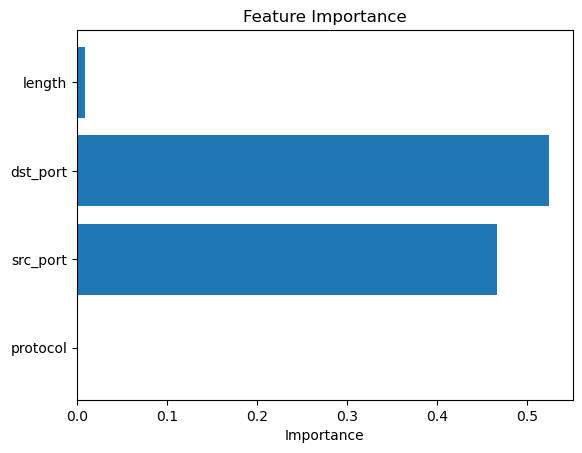

In [35]:
import matplotlib.pyplot as plt

importances = clf.feature_importances_
features = X.columns
plt.barh(features, importances)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.show()
